<a href="https://colab.research.google.com/github/jaadu-1/Algo-trading/blob/main/ProjectBcd_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

# Gradient of the objective function g(θ)
def compute_gradient(A, y, theta):
    residual = y - A @ theta
    grad = -A.T @ residual  # For least squares: ∇g = -Aᵀ(y - Aθ)
    return grad

# Projected gradient descent step (just one example: projection onto [0, 1])
def projected_descent(y, A, theta, m_it, step_size=0.01):
    for _ in range(m_it):
        grad = compute_gradient(A, y, theta)
        theta -= step_size * grad
        theta = np.clip(theta, 0, 1)  # Project onto [0,1] box constraint
    return theta

# Main Projected Block Coordinate Descent algorithm
def projected_bcd(y, A, theta0, n_it=100, m_it=10, threshold=0.5):
    theta = theta0.copy()
    k = len(theta)

    for n in range(n_it):
        grad = compute_gradient(A, y, theta)
        grad_norms = np.linalg.norm(grad, axis=-1) if grad.ndim > 1 else np.abs(grad)

        # Select indices with high gradient norm
        max_grad = np.max(grad_norms)
        I = np.where(grad_norms >= threshold * max_grad)[0]

        # Define fixed complement J
        J = np.array([j for j in range(k) if j not in I])

        # Store old theta
        theta_bar = theta.copy()

        # Create reduced θ_I and reconstruct Aφ(θ̄)
        theta_I = theta[I]
        A_theta_bar = A @ theta_bar

        # Perform projected descent on selected block
        theta_I_updated = projected_descent(y, A[:, I], theta_I, m_it)

        # Update θ
        for idx, i in enumerate(I):
            theta[i] = theta_I_updated[idx]

        # Optional: Update k if spikes change
        # k = number of nonzero elements (or spikes) in theta
        k = np.count_nonzero(theta)

    return theta


In [2]:
# Simulated problem dimensions
np.random.seed(42)
n, p = 100, 20  # 100 samples, 20 parameters
A = np.random.randn(n, p)
theta_true = np.random.rand(p)
theta_true[theta_true < 0.8] = 0  # Make it sparse (spikes)
y = A @ theta_true + 0.01 * np.random.randn(n)

# Initial guess
theta0 = np.zeros(p)

# Run Projected BCD
theta_est = projected_bcd(y, A, theta0, n_it=50, m_it=5, threshold=0.3)
print("Estimated θ:", theta_est)


Estimated θ: [0.         0.         0.         0.         0.8088545  0.94706115
 0.0442004  0.95637024 0.         0.         0.         0.
 0.         0.1654136  0.         0.         0.         0.
 0.         0.        ]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(0)


In [4]:
n, p = 100, 100  # 100 measurements, 100 parameters
A = np.random.randn(n, p)

theta_true = np.zeros(p)
spike_indices = np.random.choice(p, size=10, replace=False)
theta_true[spike_indices] = np.random.rand(10) + 0.5  # Ground truth spikes

y = A @ theta_true + 0.01 * np.random.randn(n)


In [5]:
def compute_gradient(A, y, theta):
    residual = y - A @ theta
    grad = -A.T @ residual
    return grad

def projected_descent(y, A, theta, m_it, step_size=0.01):
    for _ in range(m_it):
        grad = compute_gradient(A, y, theta)
        theta -= step_size * grad
        theta = np.clip(theta, 0, 1)
    return theta


In [6]:
def run_algorithms(y, A, theta0, n_it=200, m_it=5, threshold=0.5):
    theta_pgd = theta0.copy()
    theta_bcd = theta0.copy()

    func_vals_pgd = []
    func_vals_bcd = []
    times_pgd = []
    times_bcd = []
    frac_moving_spikes = []

    # PGD full run
    for i in range(n_it):
        start = time.time()
        grad = compute_gradient(A, y, theta_pgd)
        theta_pgd -= 0.01 * grad
        theta_pgd = np.clip(theta_pgd, 0, 1)
        end = time.time()
        times_pgd.append(end - start)
        func_vals_pgd.append(np.linalg.norm(y - A @ theta_pgd)**2)

    # PGD + BCD run
    for i in range(n_it):
        start = time.time()
        grad = compute_gradient(A, y, theta_bcd)
        grad_norms = np.abs(grad)
        max_grad = np.max(grad_norms)
        I = np.where(grad_norms >= threshold * max_grad)[0]

        # Save fraction of moving spikes
        frac_moving_spikes.append(len(I) / len(theta_bcd))

        # Mini PGD on block
        theta_I = theta_bcd[I]
        A_I = A[:, I]
        theta_I_updated = projected_descent(y, A_I, theta_I, m_it)
        theta_bcd[I] = theta_I_updated

        end = time.time()
        times_bcd.append(end - start)
        func_vals_bcd.append(np.linalg.norm(y - A @ theta_bcd)**2)

    return {
        'theta_pgd': theta_pgd,
        'theta_bcd': theta_bcd,
        'func_vals_pgd': func_vals_pgd,
        'func_vals_bcd': func_vals_bcd,
        'times_pgd': np.cumsum(times_pgd),
        'times_bcd': np.cumsum(times_bcd),
        'frac_spikes': frac_moving_spikes
    }

# Run the comparison
theta0 = np.zeros(p)
results = run_algorithms(y, A, theta0, n_it=200, m_it=5, threshold=0.5)


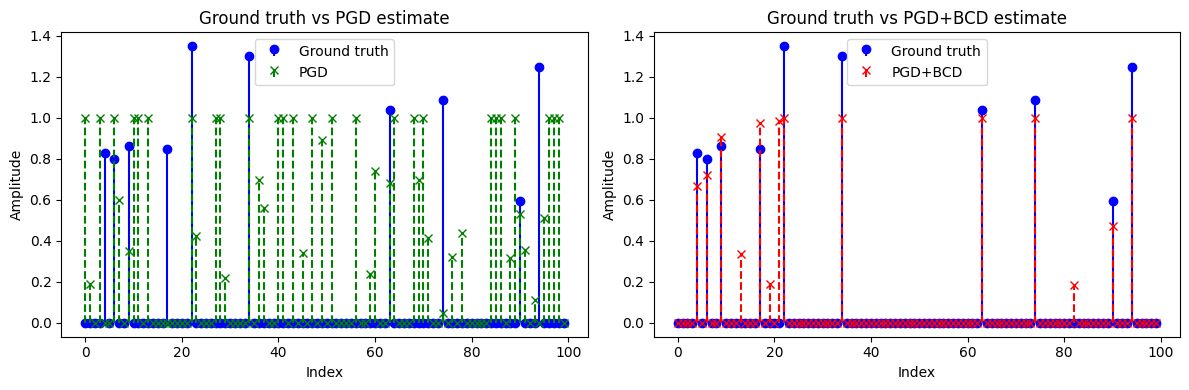

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.stem(theta_true, markerfmt='bo', linefmt='b-', basefmt=" ")
plt.stem(results['theta_pgd'], markerfmt='gx', linefmt='g--', basefmt=" ")
plt.title("Ground truth vs PGD estimate")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.legend(["Ground truth", "PGD"])

plt.subplot(1, 2, 2)
plt.stem(theta_true, markerfmt='bo', linefmt='b-', basefmt=" ")
plt.stem(results['theta_bcd'], markerfmt='rx', linefmt='r--', basefmt=" ")
plt.title("Ground truth vs PGD+BCD estimate")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.legend(["Ground truth", "PGD+BCD"])

plt.tight_layout()
plt.show()


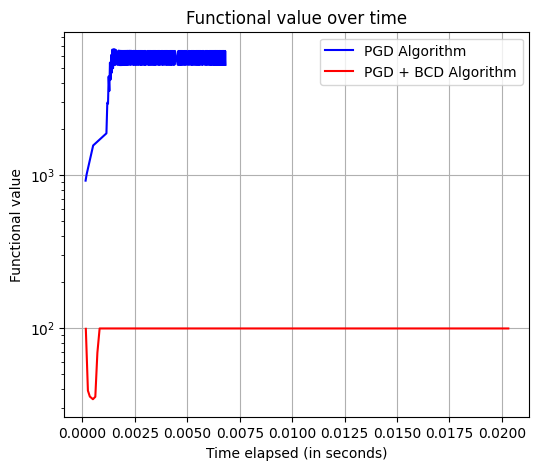

In [8]:
plt.figure(figsize=(6, 5))
plt.semilogy(results['times_pgd'], results['func_vals_pgd'], 'b-', label="PGD Algorithm")
plt.semilogy(results['times_bcd'], results['func_vals_bcd'], 'r-', label="PGD + BCD Algorithm")
plt.xlabel("Time elapsed (in seconds)")
plt.ylabel("Functional value")
plt.title("Functional value over time")
plt.grid(True)
plt.legend()
plt.show()


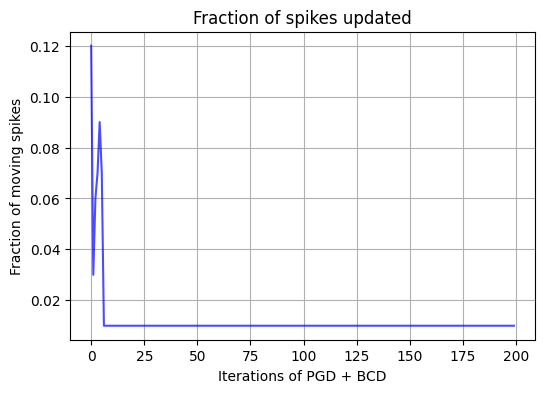

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(results['frac_spikes'], 'b-', alpha=0.7)
plt.xlabel("Iterations of PGD + BCD")
plt.ylabel("Fraction of moving spikes")
plt.title("Fraction of spikes updated")
plt.grid(True)
plt.show()


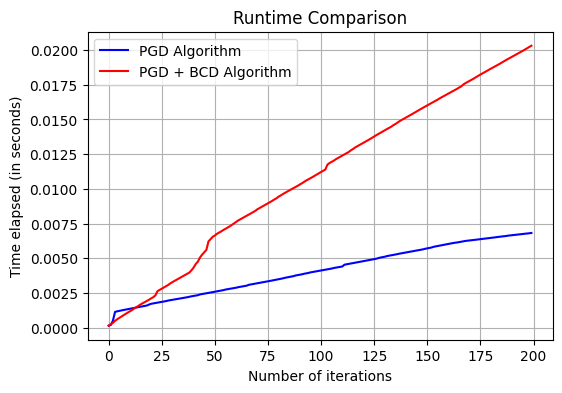

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(results['times_pgd'], 'b', label="PGD Algorithm")
plt.plot(results['times_bcd'], 'r', label="PGD + BCD Algorithm")
plt.xlabel("Number of iterations")
plt.ylabel("Time elapsed (in seconds)")
plt.title("Runtime Comparison")
plt.legend()
plt.grid(True)
plt.show()
